# Content Based Recommender Algorithm
## Movie Recommemder System using Content Based Algorithm
### This is an implementation of Content-Based Recommender Algorithm from scratch
### Dataset source: https://www.kaggle.com/tmdb/tmdb-movie-metadata

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from textwrap import wrap

# Set default fontsize and colors for graphs
SMALL_SIZE, MEDIUM_SIZE, BIG_SIZE = 12, 15, 20
plt.rc('font', size=MEDIUM_SIZE)       
plt.rc('axes', titlesize=BIG_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)  
plt.rc('xtick', labelsize=MEDIUM_SIZE) 
plt.rc('ytick', labelsize=MEDIUM_SIZE) 
plt.rc('legend', fontsize=SMALL_SIZE)  
plt.rc('figure', titlesize=BIG_SIZE)
my_colors = 'rgbkymc'

# Disable scrolling for long output
from IPython.display import display, Javascript
disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""
display(Javascript(disable_js))

<IPython.core.display.Javascript object>

## (1) Read and Prepare Data

In [2]:
# Read the input training data
input_data_file_movie = "C:\Study\DataSets\\tmdb-5000-movie-dataset\\tmdb_5000_movies.csv"
input_data_file_credit = "C:\Study\DataSets\\tmdb-5000-movie-dataset\\tmdb_5000_credits.csv"

movie_data_all = pd.read_csv(input_data_file_movie)
credit_data_all = pd.read_csv(input_data_file_credit)

In [3]:
movie_data_all.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [4]:
credit_data_all.head(2)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [5]:
print("Shape of movies dataset =", movie_data_all.shape)
print("Shape of credits dataset =", credit_data_all.shape)

Shape of movies dataset = (4803, 20)
Shape of credits dataset = (4803, 4)


## (2) Build and Test Models

## (A) Compute Weighted Rating of movies, based on the IMDB formula
### Weighted Rating = (v/(v+m) * R) + (m/(m+v) * C), where,
* v = number of votes for the movie
* m = minimum votes required to be listed in the chart
* R = average rating of the movie
* C = mean vote across the whole report

### This weighted_rating will be used later to sort the list of recommended movies

In [6]:
# Calculate the minimum number of votes required to be in the chart (top 10%)
m = movie_data_all['vote_count'].quantile(0.90)
# Calculate mean of vote across all movies
C = movie_data_all['vote_average'].mean()

# Compute the weighted rating of each movie
def weighted_rating(movies):
    v = movies['vote_count']
    R = movies['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [7]:
# Add a column weighted_rating and store the computed weighted rating for all movies
movie_data_all['weighted_rating'] = movie_data_all.apply(weighted_rating, axis=1)
movie_data_all.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,weighted_rating
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,7.050669
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,6.665696


## (B) Recommender system based on Plot (Overview) of movies

In [8]:
# Quick look at the plots
movie_data_all[['original_title', 'overview']].head(5)

,original_title,overview
0,Avatar,"In the 22nd century, a paraplegic Marine is di..."
1,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha..."
2,Spectre,A cryptic message from Bond’s past sends him o...
3,The Dark Knight Rises,Following the death of District Attorney Harve...
4,John Carter,"John Carter is a war-weary, former military ca..."


### Compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each document (overviews)

In [9]:
# Define a TF-IDF Vectorizer Object
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Remove NaN from Overview with empty strings
movie_data_all['overview'] = movie_data_all['overview'].fillna('')

# Construct TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(movie_data_all['overview'])

print("Shape of TF-IDF matrix =", tfidf_matrix.shape)

tfidf_matrix.shape

Shape of TF-IDF matrix = (4803, 20978)


(4803, 20978)

### Compute count vectors for each document (overviews) to find the most frequently occuring words

In [10]:
# Define a CountVectorizer Object
from sklearn.feature_extraction.text import CountVectorizer
cntVec = CountVectorizer(stop_words='english')

# Remove NaN from Overview with empty strings
movie_data_all['overview'] = movie_data_all['overview'].fillna('')

# Construct CountVectorizer matrix by fitting and transforming the data
cntVec_matrix = cntVec.fit_transform(movie_data_all['overview'])

print("Shape of CountVectorizer matrix =", cntVec_matrix.shape)

# Topmost frequently occuring words
words = cntVec.get_feature_names()
counts = cntVec_matrix.sum(axis=0).reshape(-1,1).tolist()
print("Most frequently occuring words in plot overview:")
word_count = dict(sorted(zip(words, counts), key=lambda x : x[1], reverse=True)[:20])
print(word_count)

Shape of CountVectorizer matrix = (4803, 20978)
Most frequently occuring words in plot overview:
{'life': [873], 'new': [719], 'young': [635], 'world': [632], 'man': [586], 'family': [541], 'story': [451], 'love': [431], 'old': [372], 'father': [360], 'years': [351], 'time': [349], 'finds': [331], 'friends': [320], 'help': [317], 'film': [315], 'town': [311], 'year': [308], 'school': [306], 'lives': [299]}


### Generate few Word Clouds, just for fun :-)

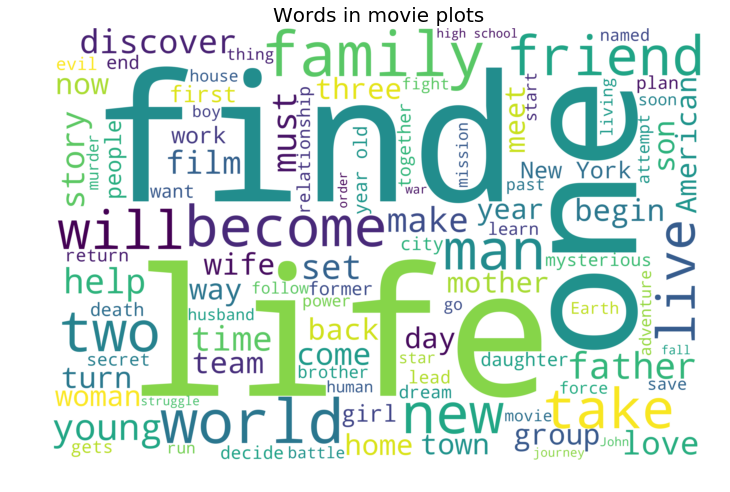

In [11]:
# Generate a word cloud image of plot overview
from wordcloud import WordCloud

overview_all = [overview for overview in movie_data_all.overview]

wordcloud = WordCloud(max_words=100, relative_scaling=0.5, background_color='white',
                      height=2000, width=3000)
wordcloud = wordcloud.generate(str(overview_all))

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Words in movie plots')
plt.show()

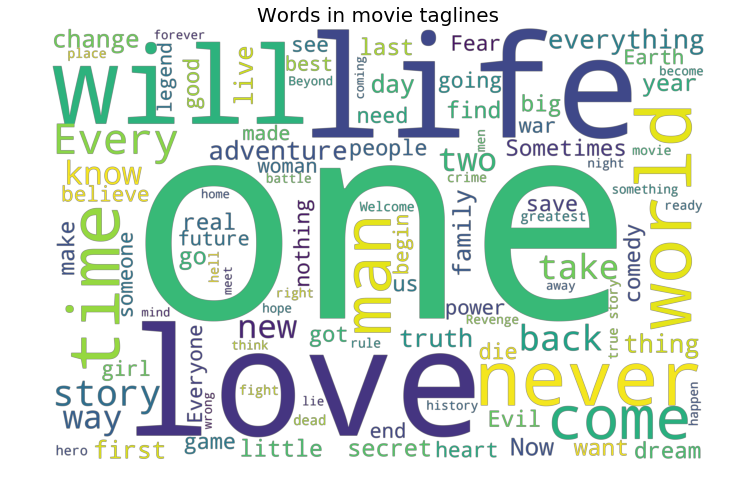

In [12]:
# Generate a word cloud image of tagline
from wordcloud import WordCloud

movie_data_all['tagline'] = movie_data_all['tagline'].fillna('')
tagline_all = [tagline for tagline in movie_data_all.tagline]

wordcloud = WordCloud(max_words=100, relative_scaling=0.5, background_color=None,
                      mode='RGBA', height=2000, width=3000)
wordcloud = wordcloud.generate(str(tagline_all))

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Words in movie taglines')
plt.show()

In [13]:
# Construct reverse mapping of movie title to movie index
# This will be used later in get recommender function 
# to fetch movie index from movie title
movie_indices = pd.Series(movie_data_all.index, index=movie_data_all['title']).drop_duplicates()
movie_indices.head(5)

title
Avatar                                      0
Pirates of the Caribbean: At World's End    1
Spectre                                     2
The Dark Knight Rises                       3
John Carter                                 4
dtype: int64

### Utility function to compute Cosine Similarity

In [14]:
# Compute cosine similarity, similar to correlation
from sklearn.metrics.pairwise import linear_kernel

def computeCosineSimilarity(word_matrix):
    cosine_similarity = linear_kernel(word_matrix, word_matrix)
    return cosine_similarity

### Utility function to compute Pearson Correlation

In [15]:
# Compute Pearson correlation
def computePearsonCorrelation(word_matrix):
    return np.corrcoef(word_matrix)

### Utility function to get recommendations for movies

In [16]:
def get_movie_recommendations(movie_title, similarity_scores):
    # Fetch index of movie based on given title
    movie_idx = movie_indices[movie_title]
    
    # Fetch similarity score of all movies with the given movie
    # Fetch it as a tuple of (index, score)
    similarity_scores = list(enumerate(similarity_scores[movie_idx]))
    
    # Sort the above score
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    
    # Pick index and score of 10 most similar movies
    # Skip the 0th index since it is same movie (itself)
    similarity_scores = similarity_scores[1:11]
    
    # Find the indices of these similar movies
    movie_similar_indices = [i[0] for i in similarity_scores]
    
    # Find title of these top movies and return
    movie_similar_titles = movie_data_all[['title', 'weighted_rating']] \
                            .iloc[movie_similar_indices] \
                            .sort_values('weighted_rating', ascending=False)
    
    return movie_similar_titles

### Test Step -> Get recommedations based on similar movie plots

In [17]:
# Find recommendations based on Cosine Similarity
cosine_similarity = computeCosineSimilarity(tfidf_matrix)
get_movie_recommendations('Spectre', cosine_similarity)

,title,weighted_rating
29,Skyfall,6.742719
4339,Dr. No,6.365479
1717,Safe Haven,6.341981
4071,From Russia with Love,6.328451
3162,Thunderball,6.187655
3336,Diamonds Are Forever,6.140231
1743,Octopussy,6.116195
11,Quantum of Solace,6.097004
1343,Never Say Never Again,6.046797
1880,Dance Flick,6.040404


In [18]:
# Find recommendations based on Pearson correlation
corrcoef_similarity = computePearsonCorrelation(tfidf_matrix.toarray())
get_movie_recommendations('Spectre', corrcoef_similarity)

,title,weighted_rating
2501,Hachi: A Dog's Tale,6.868636
29,Skyfall,6.742719
1717,Safe Haven,6.341981
4071,From Russia with Love,6.328451
1743,Octopussy,6.116195
1200,The Living Daylights,6.112995
11,Quantum of Solace,6.097004
1131,Licence to Kill,6.048478
1343,Never Say Never Again,6.046797
1880,Dance Flick,6.040404


## (C) Recommender system based on multiple features of movies - actors, director, genre and keywords

In [19]:
# Merge movies and credit dataset
movie_credit_merged = movie_data_all.merge(credit_data_all, 
                                           left_on=['id', 'title'], 
                                           right_on=['movie_id', 'title'], 
                                           how='inner')
movie_credit_merged.shape

(4803, 24)

### Few utility functions to extract/convert and store modified values in new columns
1. Convert stringified lists into dictionary
2. Fetch name of director from crew data
3. Fetch names of first 5 actors from cast data
4. Fetch names of all genres from genres data
5. Fetch first 10 keywords from keywords data

In [20]:
# Convert stringified lists data into list of dictionaries
from ast import literal_eval

features = ['cast', 'crew', 'genres', 'keywords']

for feature in features:
    movie_credit_merged[feature] = movie_credit_merged[feature].apply(literal_eval)

movie_credit_merged[features].head(1)

,cast,crew,genres,keywords
0,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...","[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 1463, 'name': 'culture clash'}, {'id':..."


In [21]:
# Find name of director from crew data
def get_director(crew):
    director = ''
    for data in crew:
        if data.get('job') == 'Director':
            director = data.get('name')
            break
        
    return director

In [22]:
# Create a new column Director and store name of director
movie_credit_merged['director'] = movie_credit_merged['crew'].apply(get_director)
movie_credit_merged.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,status,tagline,title,vote_average,vote_count,weighted_rating,movie_id,cast,crew,director
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,Released,Enter the World of Pandora.,Avatar,7.2,11800,7.050669,19995,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",James Cameron


In [23]:
# Find name of first 5 actors from cast credit roll
def get_actors(cast):
    actor_names = []
    if isinstance(cast, list):
        actor_names = [name['name'] for name in cast]
        # Check if more than 3 elements exist. If yes, 
        # return only first 5. If no, return entire list.
        if len(actor_names) > 5:
            actor_names = actor_names[:5]
        
    return actor_names

In [24]:
# Create a new column Actors and store names of Actors
movie_credit_merged['actors'] = movie_credit_merged['cast'].apply(get_actors)
movie_credit_merged.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,tagline,title,vote_average,vote_count,weighted_rating,movie_id,cast,crew,director,actors
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,Enter the World of Pandora.,Avatar,7.2,11800,7.050669,19995,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",James Cameron,"[Sam Worthington, Zoe Saldana, Sigourney Weave..."


In [25]:
# Find name of genres from genres data
def get_genres(genres):
    genre_names = []
    if isinstance(genres, list):
        genre_names = [name['name'] for name in genres]

    return genre_names

In [26]:
# Create a new column genre_names and store names of genres
movie_credit_merged['genre_names'] = movie_credit_merged['genres'].apply(get_genres)
movie_credit_merged.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,title,vote_average,vote_count,weighted_rating,movie_id,cast,crew,director,actors,genre_names
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,Avatar,7.2,11800,7.050669,19995,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",James Cameron,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[Action, Adventure, Fantasy, Science Fiction]"


In [27]:
# Find name of first 10 keywords from keywords data
def get_keywords(keywords):
    keyword_names = []
    if isinstance(keywords, list):
        keyword_names = [name['name'] for name in keywords]
        # Check if more than 10 elements exist. If yes, 
        # return only first 10. If no, return entire list.
        if len(keyword_names) > 5:
            keyword_names = keyword_names[:10]
        
    return keyword_names

In [28]:
# Create a new column keyword_names and store names of keywords
movie_credit_merged['keyword_names'] = movie_credit_merged['keywords'].apply(get_keywords)
movie_credit_merged.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,vote_average,vote_count,weighted_rating,movie_id,cast,crew,director,actors,genre_names,keyword_names
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,7.2,11800,7.050669,19995,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",James Cameron,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon..."


In [29]:
# Dataset with key features for content-based recommender system
reco_features = ['title', 'director', 'actors', 'keyword_names', 'genre_names']
movie_credit_merged[reco_features].head(5)

,title,director,actors,keyword_names,genre_names
0,Avatar,James Cameron,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[culture clash, future, space war, space colon...","[Action, Adventure, Fantasy, Science Fiction]"
1,Pirates of the Caribbean: At World's End,Gore Verbinski,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[ocean, drug abuse, exotic island, east india ...","[Adventure, Fantasy, Action]"
2,Spectre,Sam Mendes,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[spy, based on novel, secret agent, sequel, mi...","[Action, Adventure, Crime]"
3,The Dark Knight Rises,Christopher Nolan,"[Christian Bale, Michael Caine, Gary Oldman, A...","[dc comics, crime fighter, terrorist, secret i...","[Action, Crime, Drama, Thriller]"
4,John Carter,Andrew Stanton,"[Taylor Kitsch, Lynn Collins, Samantha Morton,...","[based on novel, mars, medallion, space travel...","[Action, Adventure, Science Fiction]"


### Clean up data - convert all text to lower case and trim space character between first and last names of actors and director

In [30]:
# CLean up data
def cleanUpData(data):
    if isinstance(data, list):
        return [str.lower(val.replace(" ", "")) for val in data]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(data, str):
            return str.lower(data.replace(" ", ""))
        else:
            return ''

In [31]:
# Apply data cleanup to reco features
modified_features = ['director', 'actors', 'keyword_names', 'genre_names']

for feature in modified_features:
    movie_credit_merged[feature] = movie_credit_merged[feature].apply(cleanUpData)
    
movie_credit_merged[reco_features].head(5)

,title,director,actors,keyword_names,genre_names
0,Avatar,jamescameron,"[samworthington, zoesaldana, sigourneyweaver, ...","[cultureclash, future, spacewar, spacecolony, ...","[action, adventure, fantasy, sciencefiction]"
1,Pirates of the Caribbean: At World's End,goreverbinski,"[johnnydepp, orlandobloom, keiraknightley, ste...","[ocean, drugabuse, exoticisland, eastindiatrad...","[adventure, fantasy, action]"
2,Spectre,sammendes,"[danielcraig, christophwaltz, léaseydoux, ralp...","[spy, basedonnovel, secretagent, sequel, mi6, ...","[action, adventure, crime]"
3,The Dark Knight Rises,christophernolan,"[christianbale, michaelcaine, garyoldman, anne...","[dccomics, crimefighter, terrorist, secretiden...","[action, crime, drama, thriller]"
4,John Carter,andrewstanton,"[taylorkitsch, lynncollins, samanthamorton, wi...","[basedonnovel, mars, medallion, spacetravel, p...","[action, adventure, sciencefiction]"


### Create a data soup

In [32]:
# Mix all the modified_features into soup
def createSoup(data):
    return data['director'] + ' ' + ' '.join(data['actors']) \
            + ' ' + ' '.join(data['keyword_names']) + ' ' + ' '.join(data['genre_names'])

createSoup(movie_credit_merged.iloc[0,:])

'jamescameron samworthington zoesaldana sigourneyweaver stephenlang michellerodriguez cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien action adventure fantasy sciencefiction'

In [33]:
# Create a new feature Soup with mixed data
movie_credit_merged['soup'] = movie_credit_merged.apply(createSoup, axis=1)

reco_features = ['title', 'director', 'actors', 'keyword_names', 'genre_names', 'soup']
movie_credit_merged[reco_features].head(5)

,title,director,actors,keyword_names,genre_names,soup
0,Avatar,jamescameron,"[samworthington, zoesaldana, sigourneyweaver, ...","[cultureclash, future, spacewar, spacecolony, ...","[action, adventure, fantasy, sciencefiction]",jamescameron samworthington zoesaldana sigourn...
1,Pirates of the Caribbean: At World's End,goreverbinski,"[johnnydepp, orlandobloom, keiraknightley, ste...","[ocean, drugabuse, exoticisland, eastindiatrad...","[adventure, fantasy, action]",goreverbinski johnnydepp orlandobloom keirakni...
2,Spectre,sammendes,"[danielcraig, christophwaltz, léaseydoux, ralp...","[spy, basedonnovel, secretagent, sequel, mi6, ...","[action, adventure, crime]",sammendes danielcraig christophwaltz léaseydou...
3,The Dark Knight Rises,christophernolan,"[christianbale, michaelcaine, garyoldman, anne...","[dccomics, crimefighter, terrorist, secretiden...","[action, crime, drama, thriller]",christophernolan christianbale michaelcaine ga...
4,John Carter,andrewstanton,"[taylorkitsch, lynncollins, samanthamorton, wi...","[basedonnovel, mars, medallion, spacetravel, p...","[action, adventure, sciencefiction]",andrewstanton taylorkitsch lynncollins samanth...


### Take a CountVectorizer of soup data

In [34]:
# Define a CountVectorizer Object
from sklearn.feature_extraction.text import CountVectorizer
cntVec = CountVectorizer(stop_words='english')

# Remove NaN from soup with empty strings
movie_credit_merged['soup'] = movie_credit_merged['soup'].fillna('')

# Construct CountVectorizer matrix by fitting and transforming the data
cntVec_matrix = cntVec.fit_transform(movie_credit_merged['soup'])

print("Shape of CountVectorizer matrix =", cntVec_matrix.shape)

# Topmost frequently occuring words
words = cntVec.get_feature_names()
counts = cntVec_matrix.sum(axis=0).reshape(-1,1).tolist()
print("Most frequently occuring words in plot overview:")
word_count = dict(sorted(zip(words, counts), key=lambda x : x[1], reverse=True)[:20])
print(word_count)

Shape of CountVectorizer matrix = (4803, 19502)
Most frequently occuring words in plot overview:
{'drama': [2307], 'comedy': [1746], 'thriller': [1276], 'action': [1157], 'romance': [915], 'adventure': [806], 'crime': [705], 'family': [569], 'sciencefiction': [540], 'horror': [530], 'fantasy': [442], 'mystery': [353], 'independentfilm': [286], 'womandirector': [264], 'animation': [257], 'duringcreditsstinger': [231], 'music': [225], 'history': [204], 'basedonnovel': [197], 'war': [181]}


### Test Step -> Get recommedations based on similar actors, directors, genres and keywords of movies

In [35]:
# Find recommendations based on Cosine Similarity
cosine_similarity = computeCosineSimilarity(cntVec_matrix)
get_movie_recommendations('Spectre', cosine_similarity)

,title,weighted_rating
277,Casino Royale,6.909992
29,Skyfall,6.742719
134,Mission: Impossible - Rogue Nation,6.734009
370,Now You See Me 2,6.479747
11,Quantum of Solace,6.097004
1077,Johnny English,6.062983
1100,Johnny English Reborn,6.059552
1234,The Art of War,6.058502
1343,Never Say Never Again,6.046797
1084,The Glimmer Man,6.020351


In [36]:
# Find recommendations based on Pearson correlation
corrcoef_similarity = computePearsonCorrelation(cntVec_matrix.toarray())
get_movie_recommendations('Spectre', corrcoef_similarity)

,title,weighted_rating
29,Skyfall,6.742719
134,Mission: Impossible - Rogue Nation,6.734009
11,Quantum of Solace,6.097004
3318,Witless Protection,6.062995
1100,Johnny English Reborn,6.059552
1234,The Art of War,6.058502
1343,Never Say Never Again,6.046797
1084,The Glimmer Man,6.020351
2050,The Transporter Refueled,5.884145
2046,RoboCop 3,5.822921


### Many thanks to this wonderful tutorial: https://www.datacamp.com/community/tutorials/recommender-systems-python